In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service
rsp_tap = get_tap_service("tap")

Define the DP1 field centers.

In [2]:
snames = ['47Tuc', 'LowEclLat', 'Fornax', 'ECDFS',
         'EDFS', 'LowGalLat', 'Seagull']
ras = [6.02, 37.86, 40.00, 53.13, 59.10, 95.00, 106.23]
decs = [-72.08, 6.98, -34.45, -28.10, -48.73, -25.00, -10.51]

## 1. Just 5 rows

The short `byw.csv` runs just fine. No matches, but that is to be expected from just 5 rows.

In [3]:
ut1 = Table.read('byw_short.csv', format='csv')
ut1

<Table length=5>
BYWid shortname catWISE_RA catWISE_Dec
int64    str9    float64     float64  
----- --------- ---------- -----------
    0 0000+4437  0.0087419  44.6236809
    1 0000-7048   0.024753 -70.8142748
    2 0000-4614  0.0678658 -46.2490076
    3 0000+2454  0.0864696  24.9051138
    4 0000-4813  0.0893808 -48.2208077

In [4]:
query = """
        SELECT objectId, coord_ra, coord_dec,
        ut1.catWISE_RA AS ut1_ra, ut1.catWISE_Dec AS ut1_dec, ut1.BYWid AS ut1_objid
        FROM dp1.Object, TAP_UPLOAD.ut1 AS ut1
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
        CIRCLE('ICRS', ut1.catWISE_RA, ut1.catWISE_Dec, 0.00027))=1
        ORDER BY coord_ra ASC
        """

In [5]:
job = rsp_tap.submit_job(query, uploads={"ut1": ut1})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [6]:
assert job.phase == 'COMPLETED'
results = job.fetch_result()
print(len(results))

0


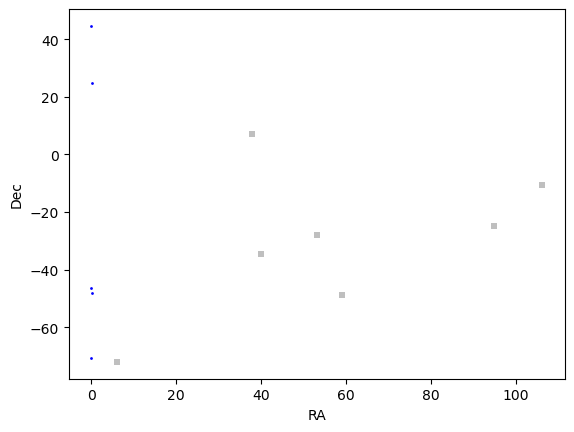

In [8]:
plt.plot(ras, decs, 's', ms=5, mew=0, alpha=0.5, color='grey')
plt.plot(ut1['catWISE_RA'], ut1['catWISE_Dec'], 'o', ms=2, mew=0, alpha=1, color='blue')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [9]:
del ut1, results

## 2. Use all 4226 rows

This also runs, but still yeilds no matches.

In [10]:
ut1 = Table.read('reducedBYW.csv', format='csv')
ut1

<Table length=4226>
BYWid shortname  catWISE_RA catWISE_Dec
int64    str9     float64     float64  
----- --------- ----------- -----------
    0 0000+4437   0.0087419  44.6236809
    1 0000-7048    0.024753 -70.8142748
    2 0000-4614   0.0678658 -46.2490076
    3 0000+2454   0.0864696  24.9051138
    4 0000-4813   0.0893808 -48.2208077
    5 0000+3156   0.0932102  31.9480563
    6 0000-7742   0.1169071 -77.7129662
    7 0000+5747   0.1420743  57.7833527
    8 0000+3548    0.245482  35.8148546
  ...       ...         ...         ...
 4216 2357+3908 359.3395148  39.1348144
 4217 2357-4703 359.4146496 -47.0503862
 4218 2358-5142 359.5075632  -51.710795
 4219 2358-5218 359.6165101 -52.3037451
 4220 2358-5529 359.6560798  -55.499753
 4221 2359+5036 359.8271264  50.6045235
 4222 2359-7557 359.8616506 -75.9647602
 4223 2359-0850 359.9061279  -8.8376159
 4224 2359-3935 359.9447667 -39.5889683
 4225 2359-2809 359.9730301 -28.1659999

In [11]:
query = """
        SELECT objectId, coord_ra, coord_dec,
        ut1.catWISE_RA AS ut1_ra, ut1.catWISE_Dec AS ut1_dec, ut1.BYWid AS ut1_objid
        FROM dp1.Object, TAP_UPLOAD.ut1 AS ut1
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
        CIRCLE('ICRS', ut1.catWISE_RA, ut1.catWISE_Dec, 0.00027))=1
        ORDER BY coord_ra ASC
        """

In [12]:
job = rsp_tap.submit_job(query, uploads={"ut1": ut1})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [13]:
assert job.phase == 'COMPLETED'
results = job.fetch_result()
print(len(results))

0


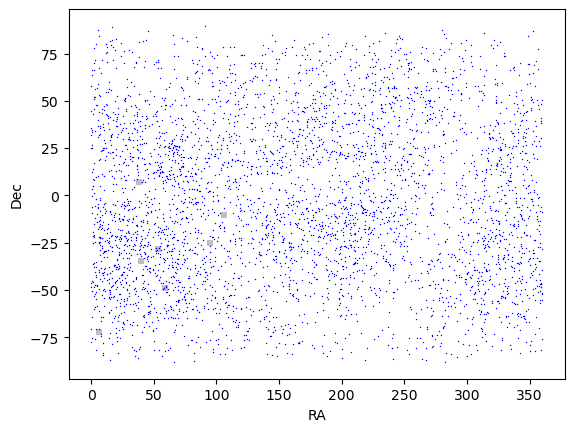

In [14]:
plt.plot(ras, decs, 's', ms=5, mew=0, alpha=0.5, color='grey')
plt.plot(ut1['catWISE_RA'], ut1['catWISE_Dec'], 'o', ms=1, mew=0, alpha=1, color='blue')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [15]:
del ut1, results

## 3. Pre-select rows and use a larger x-match radius

Down-select rows of `ut1` to only coordinates near one of the seven DP1 fields.

In [16]:
ut1 = Table.read('reducedBYW.csv', format='csv')
# ut1

Flag objects in `ut1` that are within a generous 4 degree radius of a DP1 field.

In [17]:
flag = np.zeros(len(ut1), dtype='int')
for ra, dec in zip(ras, decs):
    cosdec = np.cos(np.deg2rad(dec))
    tx = np.where(((ra-ut1['catWISE_RA'])*cosdec)**2 + (dec-ut1['catWISE_Dec'])**2 < 4**2)[0]
    flag[tx] = 1
tx = np.where(flag == 1)[0]
print(len(tx), ' flagged as "near" DP1')

45  flagged as "near" DP1


Remove unflagged objects from `ut1`.

In [18]:
tx = np.where(flag == 0)[0]
ut1.remove_rows(tx)

In [19]:
# ut1

Use a larger cross-match radius of 5" (0.001 deg) to see if we can get some matches.

In [20]:
query = """
        SELECT objectId, coord_ra, coord_dec,
        ut1.catWISE_RA AS ut1_ra, ut1.catWISE_Dec AS ut1_dec, ut1.BYWid AS ut1_objid
        FROM dp1.Object, TAP_UPLOAD.ut1 AS ut1
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
        CIRCLE('ICRS', ut1.catWISE_RA, ut1.catWISE_Dec, 0.001))=1
        ORDER BY coord_ra ASC
        """

In [21]:
job = rsp_tap.submit_job(query, uploads={"ut1": ut1})
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [22]:
assert job.phase == 'COMPLETED'
results = job.fetch_result()
print(len(results))

0


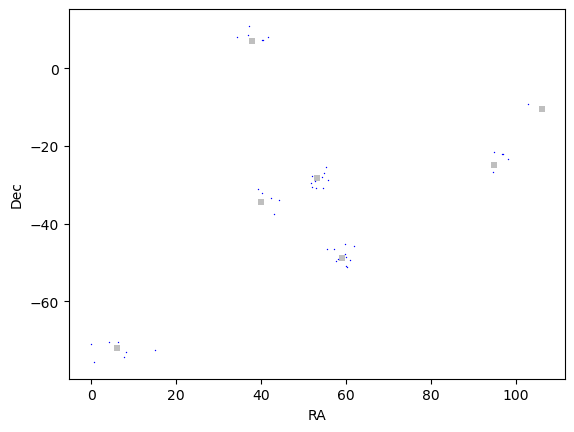

In [23]:
plt.plot(ras, decs, 's', ms=5, mew=0, alpha=0.5, color='grey')
plt.plot(ut1['catWISE_RA'], ut1['catWISE_Dec'], 'o', ms=1, mew=0, alpha=1, color='blue')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

## 4. Use the portal to confirm no overlap

Write a file that just has the down-selected rows of `ut1` and only the RA, Dec columns.

In [24]:
fout = open('reducedBYW_subset.csv', 'w')
fout.write('ra, dec \n')
for i in range(len(ut1)):
    fout.write('%12.7f, %12.7f \n' % (ut1['catWISE_RA'][i], ut1['catWISE_Dec'][i]))
fout.close()

Use the "Upload" tab to upload this file to the Portal Aspect. 

In the Portal results interface, browse the file's coordinates overplotted on the HiPS map and see there is no actual overlap.

This screenshot is a zoom-out for one DP1 field (the default zoom is to be very zoomed-in on the coordinates of the first row).

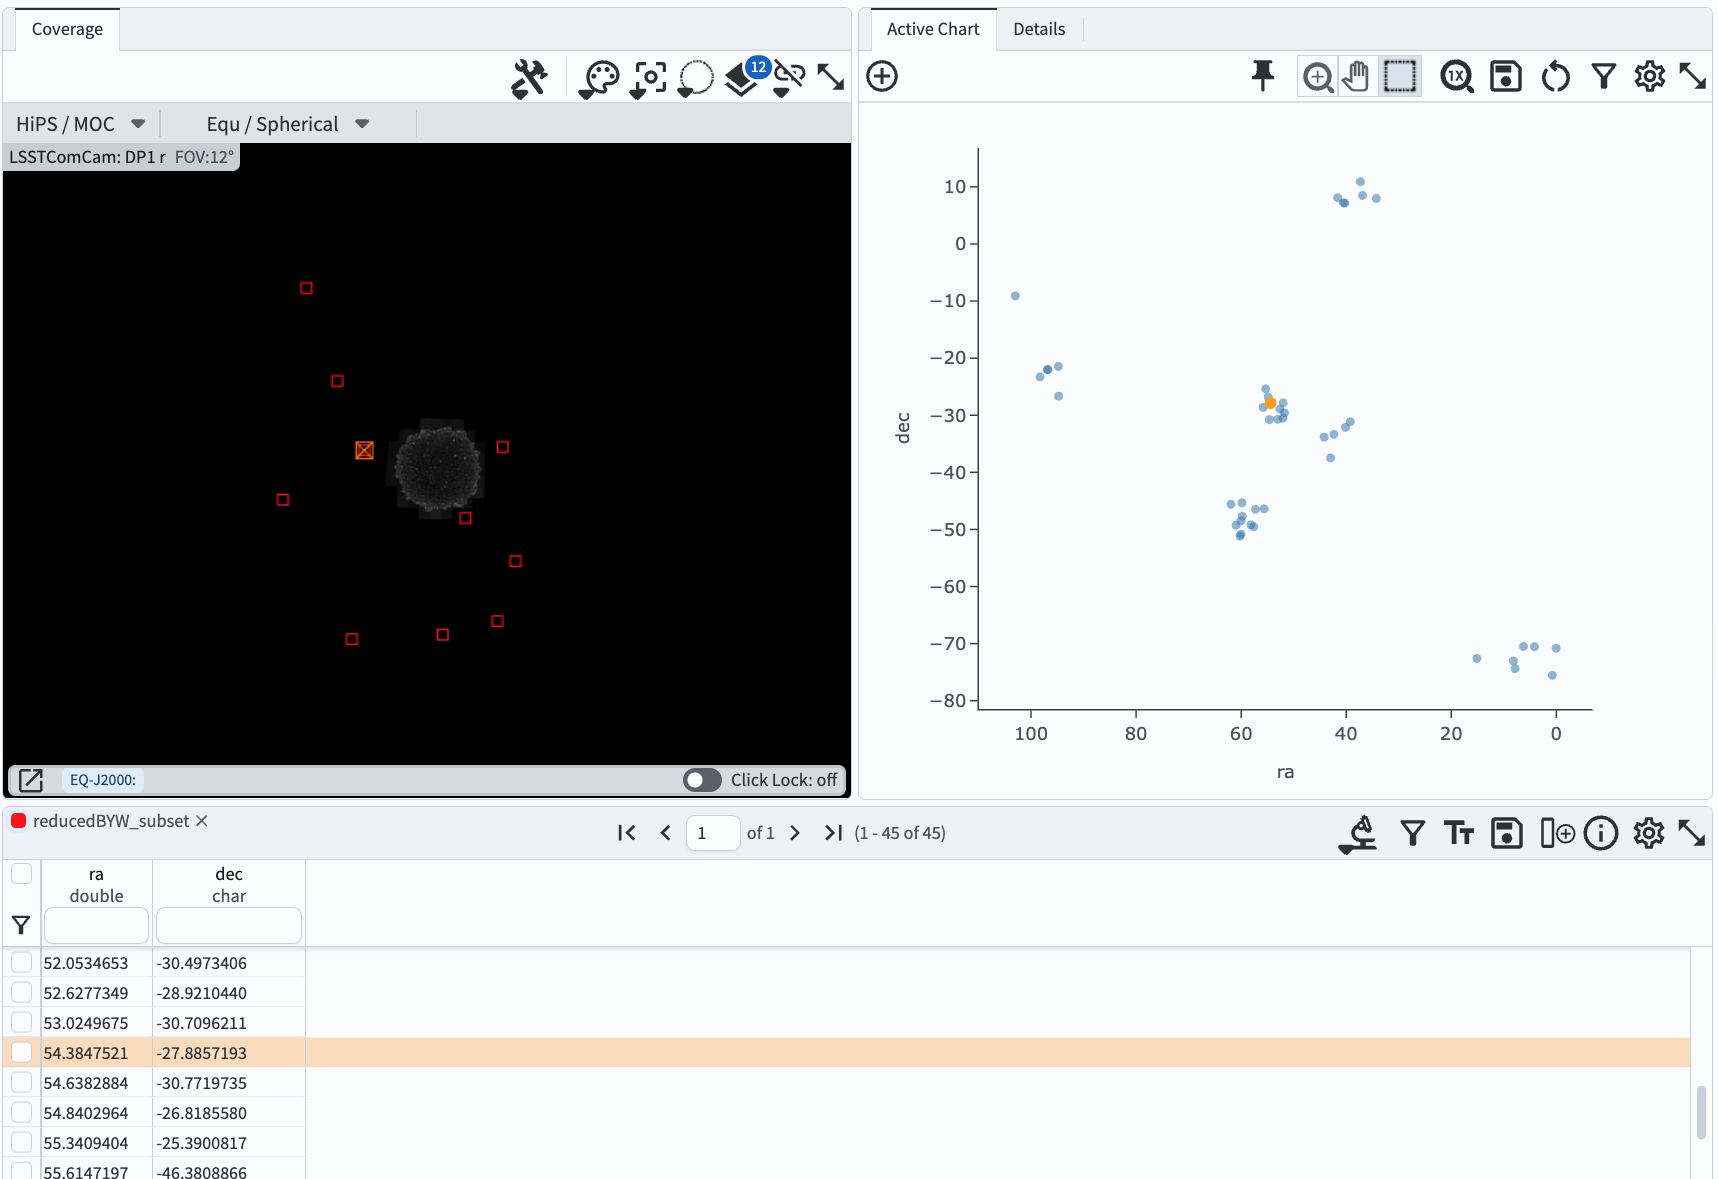